In [1]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import sys
sys.path.append('/gpfs01/bethge/home/sschneider/thesis/code/domainadaptation')

import analysis
%load_ext autoreload
%autoreload 2

In [2]:
import datasets, noise

noise_var = [g.sigma for g in datasets.clean2noise()]
n_domains = len(noise_var)

In [190]:
import itertools
import numpy as np

l_shape = (n_domains,n_domains,26032)
y_shape = (n_domains,n_domains,26032, 10)

lbl  = np.zeros(l_shape)
pred = np.zeros(y_shape)

#with h5py.File('20180820-200625-checkpoint-ep90-clean.hdf5', 'r') as ds:
with h5py.File('20180820-200427-checkpoint-ep90-noise.hdf5', 'r') as ds:
    
    for i,j in itertools.product(range(n_domains), range(n_domains)):
    
        key       = '{}_{}'.format(i,j)
                
        grp       = ds.require_group(key)
        
        lbl[i,j]  = grp['lbl'][...]
        pred[i,j] = grp['pred'][...]
        
H = np.equal(lbl, pred.argmax(axis=-1))
ACC = H.mean(axis=-1)

ACC = ACC[::-1, ::-1]

x = np.stack(np.random.normal(0,v,(28,28)) for v in noise_var)
results = ACC.T
ACC.shape

(9, 9)

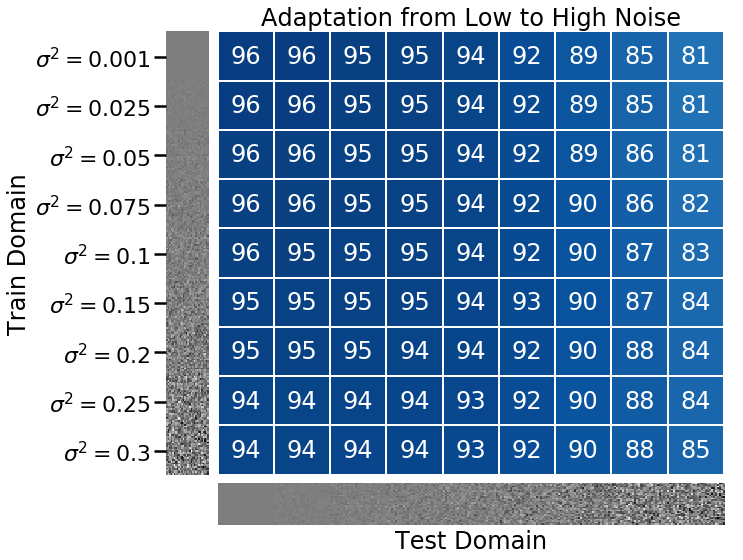

In [191]:
ax = analysis.plot_overview(ACC, x, noise_var) 
ax.set_title('Adaptation from Low to High Noise')

plt.show()

In [192]:
import glob

#fnames = list(glob.glob('log/multi_noise_bn/clean/20180820-200625_MultidomainBCESolver/20180820-200625-checkpoint-ep9*.pth'))
fnames = list(glob.glob('log/multi_noise_bn/noise/20180820-200427_MultidomainBCESolver/20180820-200427-checkpoint-ep9*.pth'))

P = analysis.load_params(fnames)
P.shape

0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
10 4


(4, 9, 11, 2176)

In [193]:
M, B = analysis.compute_linear(P[:,:,:])
M.shape, B.shape

((9, 11, 2176), (9, 11, 2176))

In [194]:
P.shape

(4, 9, 11, 2176)

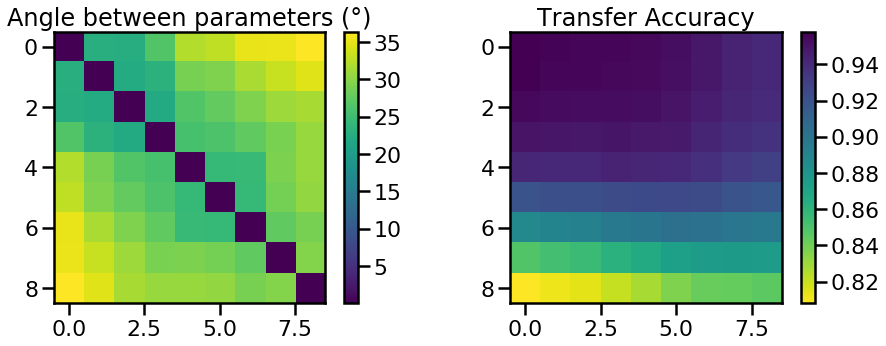

In [195]:
m = P[3,:,-1,:]

a    = m.dot(m.T)
norm = (m**2).sum(axis=-1)**.5

cos_a = a / (norm[np.newaxis,:] * norm[:,np.newaxis])
cos_a = np.clip(cos_a,-1,1)
a = np.arccos(cos_a)

fig, (ax_angle, ax_acc) = plt.subplots(1,2,figsize=(15,5))

cax = ax_angle.imshow(a*180/np.pi)
plt.colorbar(ax=ax_angle, mappable=cax)
ax_angle.set_title("Angle between parameters (°)")

cax = ax_acc.imshow(ACC, cmap='viridis_r')
plt.colorbar(ax=ax_acc, mappable=cax)
ax_acc.set_title("Transfer Accuracy")

plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


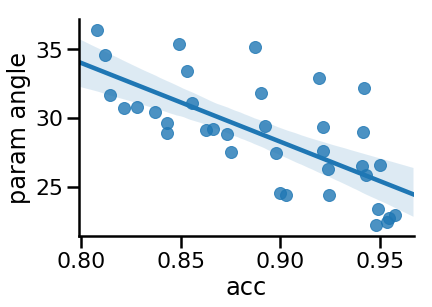

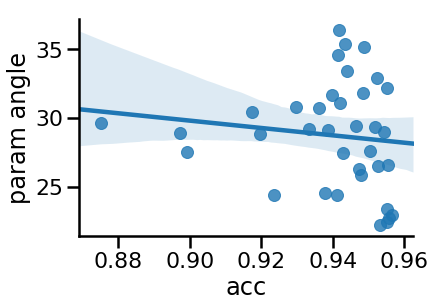

In [196]:
def plot_reg(x,y):

    sns.regplot(x, y*180/np.pi)
    sns.despine()

    plt.xlabel('acc')
    plt.ylabel('param angle')
    

x = np.tril(ACC, 1)
y = np.tril(a, 1)
idc = np.tril(np.ones((len(x), len(y)))) > 0

x = x[idc]
y = y[idc]
x = x[y>0.001]
y = y[y>0.001]

plot_reg(x, y)
plt.show()

x = np.triu(ACC, 1)
y = np.triu(a, 1)
idc = np.triu(np.ones((len(x), len(y)))) > 0

x = x[idc]
y = y[idc]
x = x[y>0.001]
y = y[y>0.001]

plot_reg(x, y)
plt.show()

In [11]:
par = P[:,:,-1]

par.shape, noise_var

((4, 9, 2176), [0.001, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3])

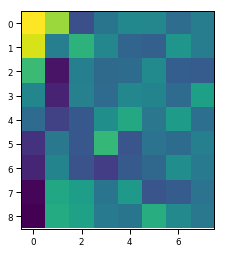

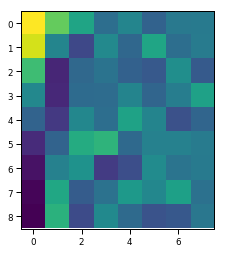

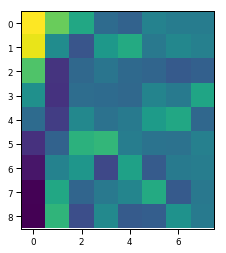

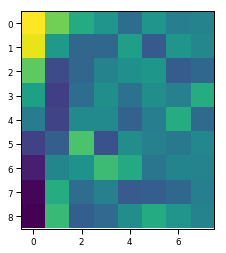

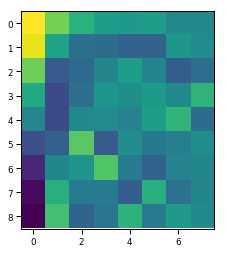

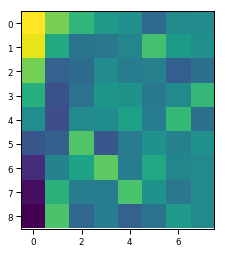

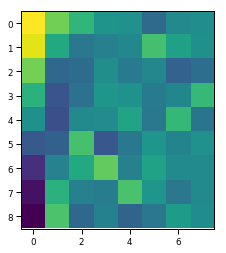

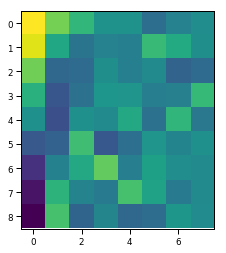

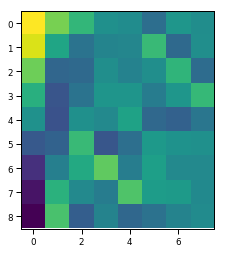

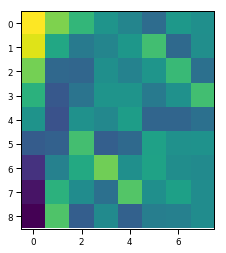

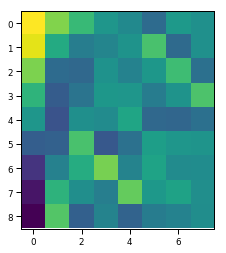

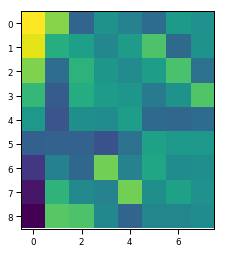

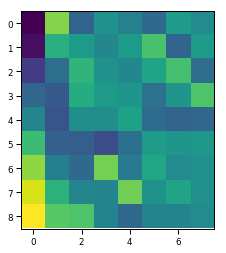

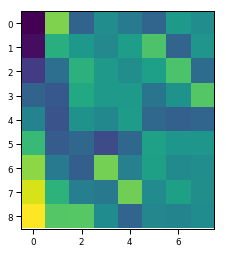

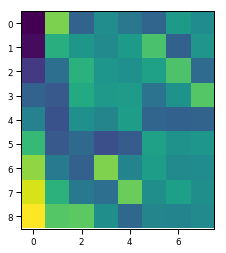

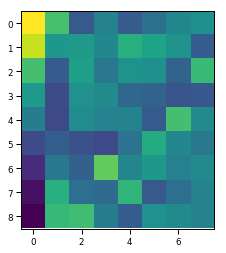

In [185]:
from sklearn.decomposition import PCA

for n in range(128,par.shape[-1],128):
    pca = PCA(n_components=8, whiten=False)
    pcs = pca.fit_transform(par[2,:, :n])
    plt.imshow(pcs)
    plt.show()

(8, 2048)


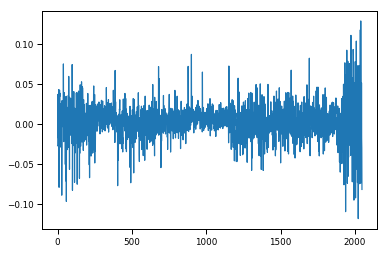

In [39]:
print(pca.components_.shape)

plt.plot(pca.components_[5])
plt.show()

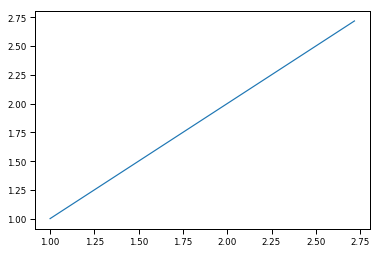

In [64]:
x = np.linspace(0,1)
y = x.copy()

#plt.plot(x,y)
plt.plot(np.exp(x), np.exp(y))

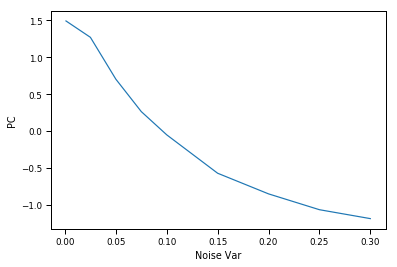

In [78]:
plt.plot(noise_var, pcs[:,0])
    
plt.xlabel('Noise Var')
plt.ylabel('PC')
plt.show()

Text(0,0.5,'PC')

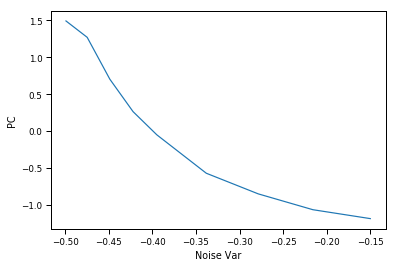

In [59]:
for i in range(1):
    plt.plot(np.exp(noise_var) - 1.5, pcs[:,i], alpha=1-i/4, c = 'C0')
    
plt.xlabel('Noise Var')
plt.ylabel('PC')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


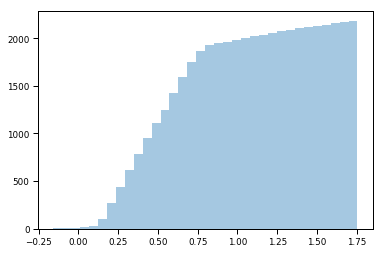

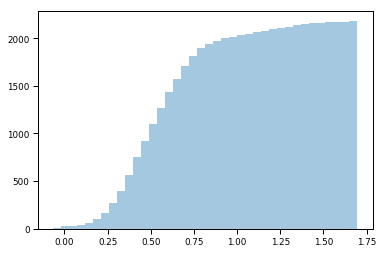

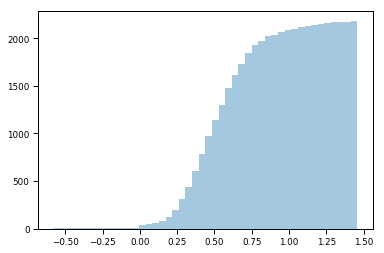

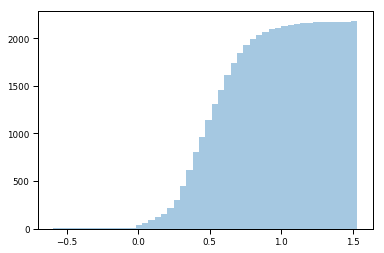

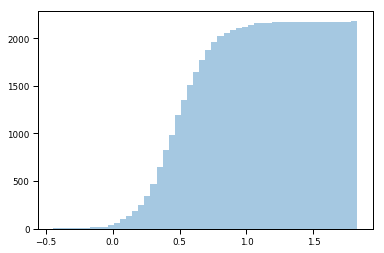

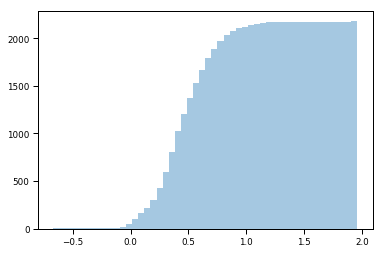

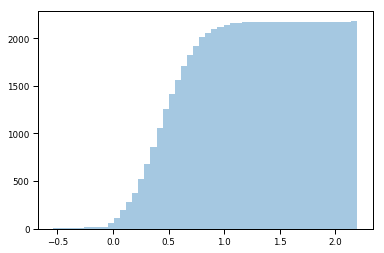

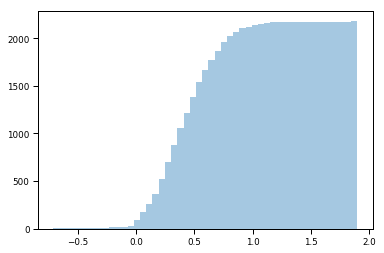

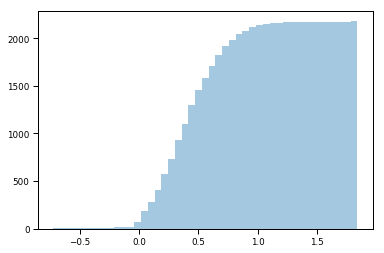

In [26]:
sns.set_context('paper')

for n, var in enumerate(noise_var):
    sns.distplot(par[2,n], hist_kws=dict(cumulative=True),
                kde = None)
    plt.show()

In [89]:
par.shape

(4, 9, 2176)

[41.31481148 14.437455    7.18900693  6.34547524  6.08746544  5.41255592
  4.39524428  4.09093938  3.51359929]


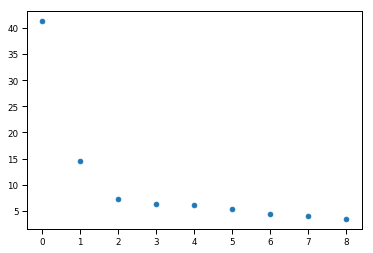

In [88]:
u,s,vh = np.linalg.svd(par[3])

plt.scatter(np.arange(len(s)), s)
print(s)

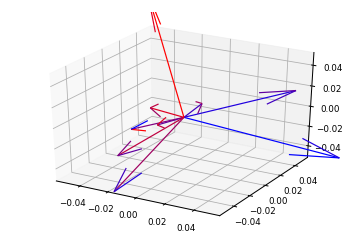

In [171]:
origin = [0], [0], [0] # origin point

from mpl_toolkits.mplot3d import axes3d

c = np.stack([  np.linspace(0,1,len(pcs)),
                np.zeros(len(pcs)),
                1 - np.linspace(0,1,len(pcs)),
                ], axis=-1)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.quiver(*origin, pcs[:,0], pcs[:,1], pcs[:,2], length=.05,
         color = c)
plt.show()

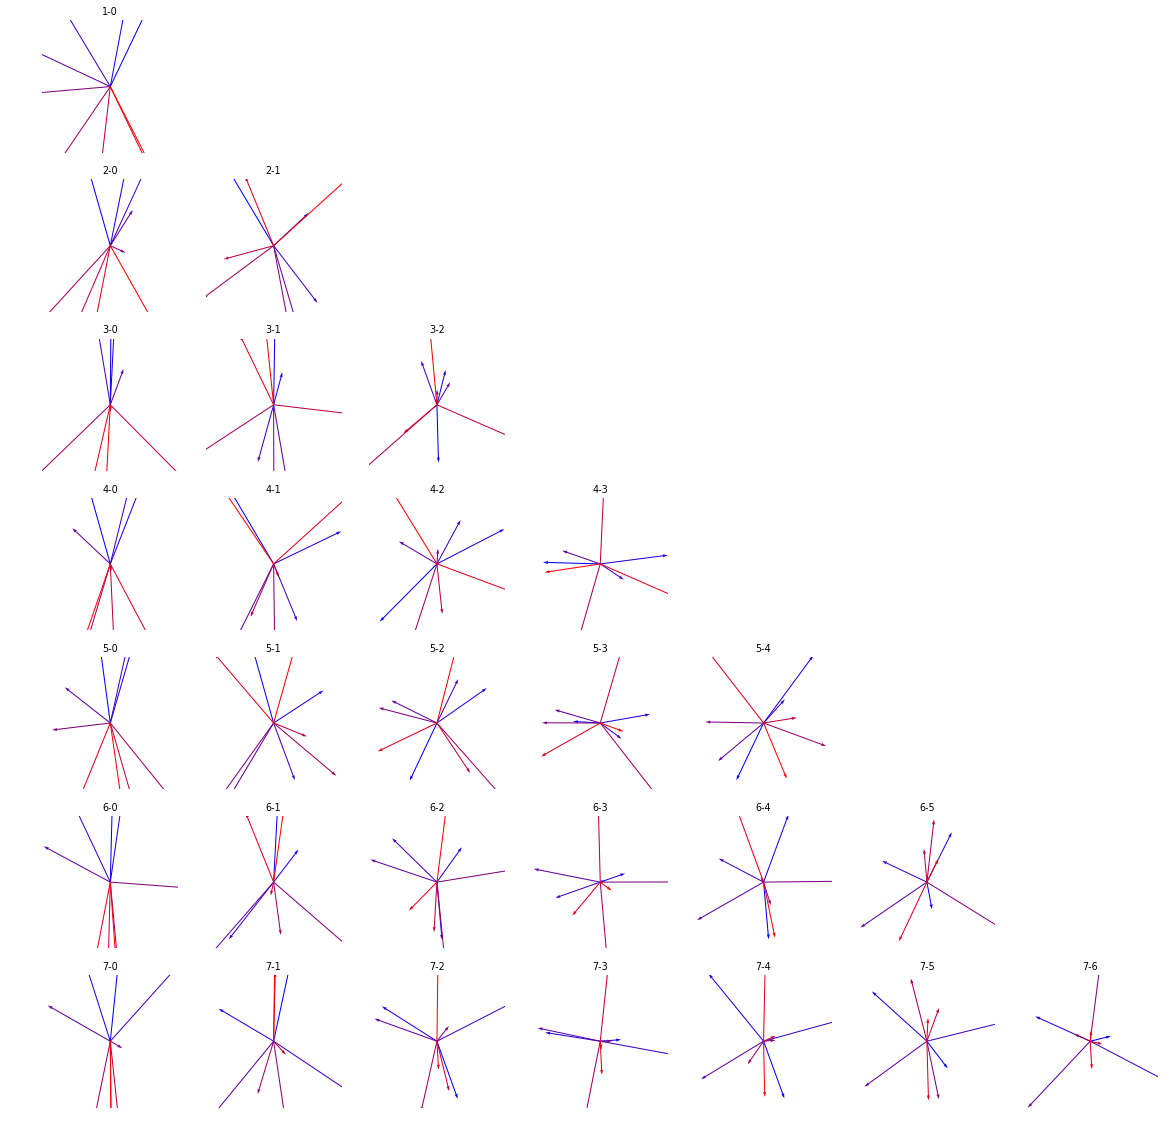

In [186]:
n_components = 8

fig, axes = plt.subplots(n_components-1,n_components-1,figsize=(20,20))

for i in range(n_components):
    for j in range(i):

        #cax = .scatter(Y[:,i], Y[:,j], c=c, s = 2, alpha=.6, cmap='coolwarm')
        axes[i-1,j].quiver(*origin[:2], pcs[:,i], pcs[:,j], scale=5, color = c)
        
        axes[i-1,j].axis('off')
        axes[i-1,j].set_title('{}-{}'.format(i,j))



    for j in range(i, n_components-1):
        axes[i-1,j].axis('off')

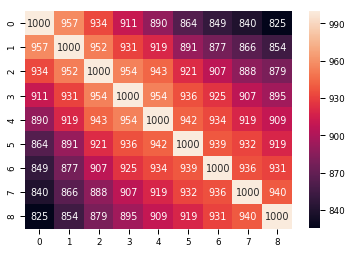

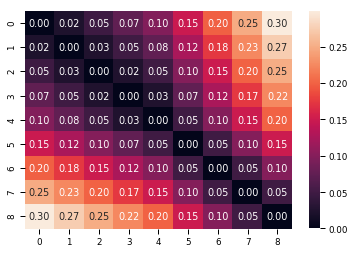

In [122]:
m = P[2,:,-1,:]

a    = m.dot(m.T)
norm = (m**2).sum(axis=-1)**.5

cos_a = a / (norm[np.newaxis,:] * norm[:,np.newaxis])
cos_a = np.clip(cos_a,-1,1)
a = np.arccos(cos_a)

sns.heatmap(cos_a*1000, annot=True, fmt='.0f')
plt.show()

noise_var = np.array(noise_var)

diff = abs(noise_var[:,np.newaxis] - noise_var[np.newaxis,:])

sns.heatmap(diff, annot=True, fmt='.2f')
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


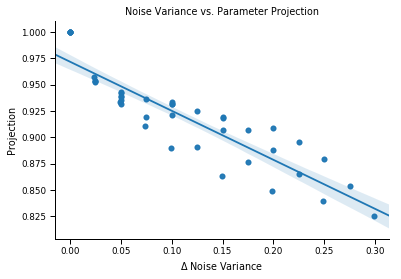

In [131]:
sns.regplot(diff.flatten(), cos_a.flatten())
plt.xlabel('$\Delta$ Noise Variance')
plt.ylabel('Projection')

plt.title('Noise Variance vs. Parameter Projection')

sns.despine()